In [52]:
import numpy as np 
import pandas as pd
import os
import psycopg2
import geopandas as gpd

import importlib
from Secrets import secrets
# importlib.reload(secrets)

import matplotlib.pyplot as plt
import seaborn as sns

### Analysis

 - num of sales, avg price by areas 

 - AVG price per sq ft over time
 - num of transactions over time
 - - AVG price per sq ft by geography over time
 

### Pull Data from a custom made AWS Database of public data
Define an engine to query AWS DB and set up the execution

In [178]:
# Define Engine
engine = psycopg2.connect(
    database="postgres",
    user=secrets.user(),
    password=secrets.password(),
    host=secrets.host(),
    port='5432'
)
cur = engine.cursor()

## Avg price and num of transactions over time and by region

In [58]:
# Get Data from AWS RDS PostgresSQL DB (all data within the database is publicly available and been scrapped and collected by myself)

cur.execute("""

SELECT 
    g.rg_name as region,  CAST (p.year AS INTEGER), CAST(ROUND(AVG(p.price)::numeric,0 ) as integer) as avg_price, count(*) as count 

from prices as p
join geo as g 
on g.lsoa = p.lsoa
group by g.rg_name, p.year;

""")
rows = cur.fetchall()
result = pd.DataFrame(rows, columns = [desc[0] for desc in cur.description])
result.head(2)

,region,year,avg_price,count
0,Barking and Dagenham,1995,50615,1488
1,Barking and Dagenham,1996,51670,1892
2,Barking and Dagenham,1997,56226,2442
3,Barking and Dagenham,1998,63874,2516
4,Barking and Dagenham,1999,69544,2699


CAGR (1995-2019) - 11.11%


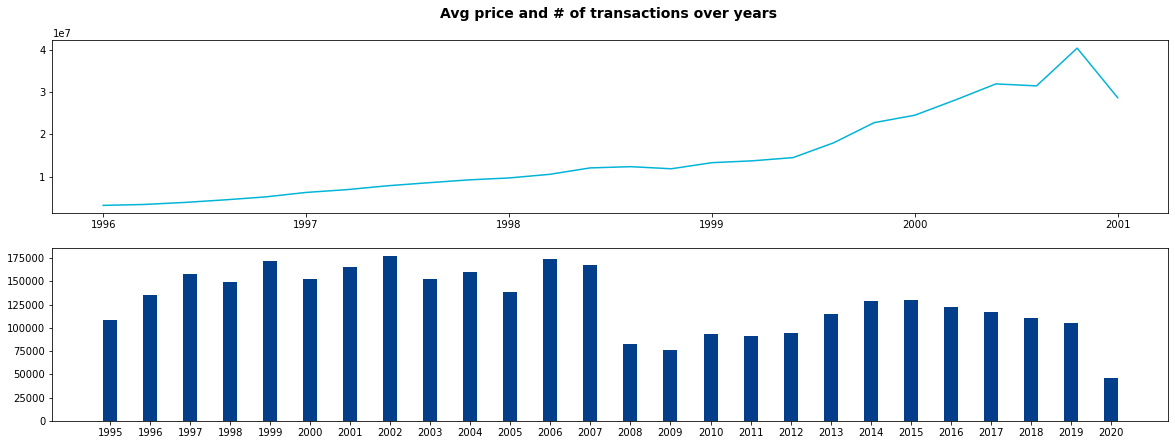

In [173]:
# Overal view of prices and num of transactions

cagr1995_2019 = pow(result_gp[result_gp.year == 2019]["avg_price"].iloc[0]/ result_gp[result_gp.year == 1995]["avg_price"].iloc[0], (1/(result_gp.shape[0]-2)) ) -1
print("CAGR (1995-2019) - {:.2f}%".format(cagr1995_2019*100) )

result_gp = result.groupby("year", as_index=False).sum()

fig, ax = plt.subplots(ncols =1, nrows = 2, figsize=(20, 7))

ax[0].set_title("Avg price and # of transactions over years \n", fontweight='bold', fontsize=14)
ax[0].plot(result_gp["avg_price"], color="#00b4d8")

width = 0.35
labels = result_gp["year"].values
x = np.arange(len(labels))
y = result_gp["count"].values
ax[1].bar(x, y, width, color="#023e8a")
ax[1].set_xticks(x)
ax[1].set_xticklabels(labels)
ax[0].set_xticklabels(labels)

plt.show()



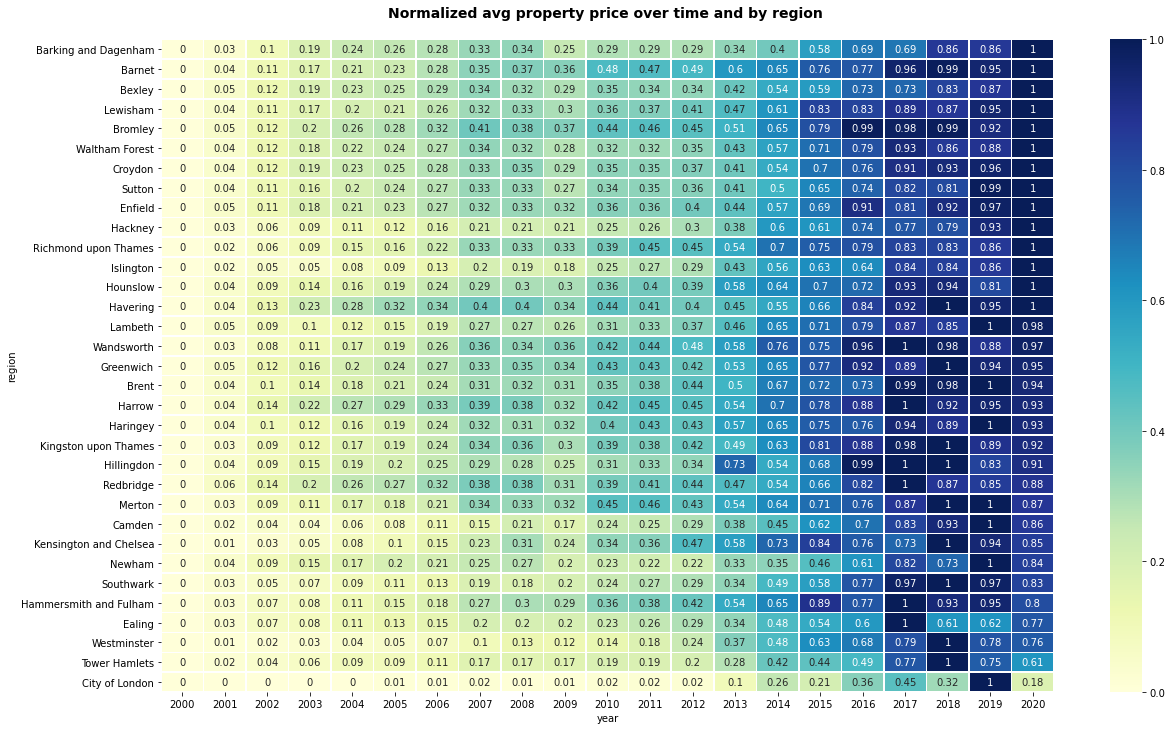

In [106]:
#### By Region view prices
####

# Reshape data into pivot table
result_pv = pd.pivot_table(result[result.year > 1999], index="region", columns="year", values="avg_price")
# Normalize data across each row, for each region ensure the avg price is represented as a number between 0 and 1
result_pv2 = result_pv.subtract(result_pv.min(axis=1), axis=0).div(result_pv.max(axis=1) -result_pv.min(axis=1), axis=0).round(2).sort_values(by=2020, ascending=False)

# Plot 
fig, ax = plt.subplots(figsize=(20, 12))
sns.heatmap(result_pv2, annot=True, linewidths=.5, ax=ax, cmap="YlGnBu")
ax.set_title("Normalized avg property price over time and by region \n", fontweight='bold', fontsize=14)
plt.show()

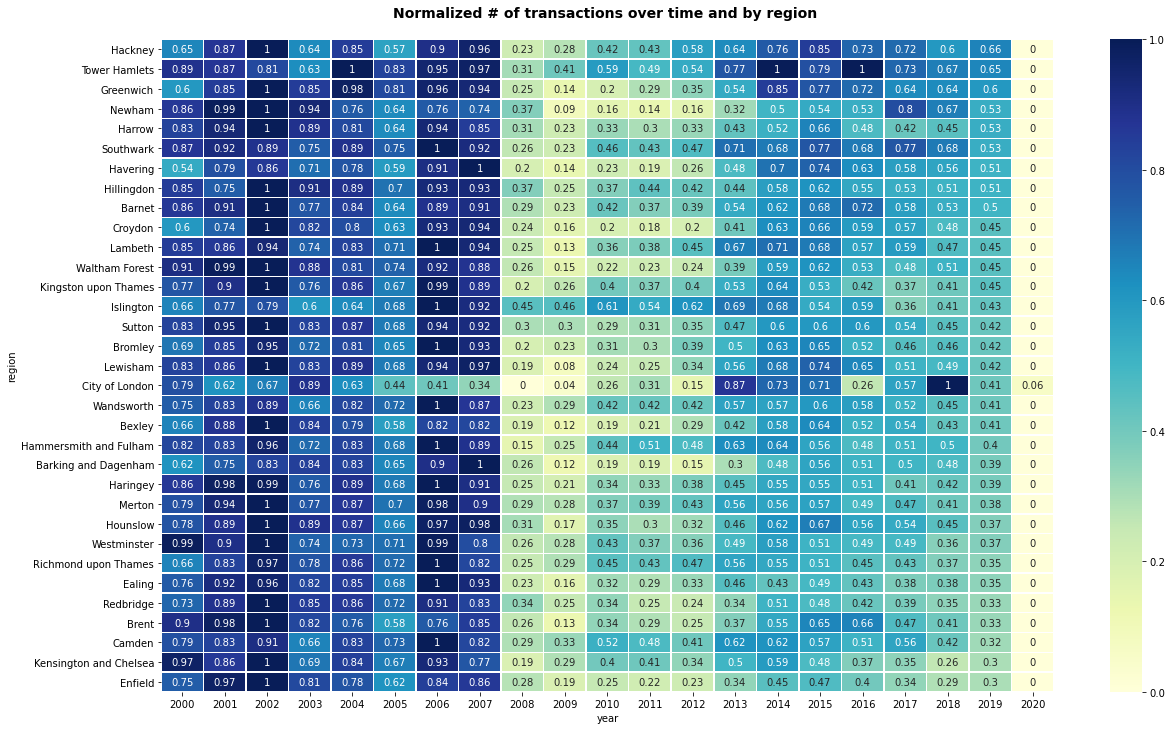

In [108]:
#### By Region view prices
####

# Reshape data into pivot table
result_pv = pd.pivot_table(result[result.year > 1999], index="region", columns="year", values="count")
# Normalize data across each row, for each region ensure the avg price is represented as a number between 0 and 1
result_pv2 = result_pv.subtract(result_pv.min(axis=1), axis=0).div(result_pv.max(axis=1) -result_pv.min(axis=1), axis=0).round(2).sort_values(by=2019, ascending=False)

# Plot 
fig, ax = plt.subplots(figsize=(20, 12))
sns.heatmap(result_pv2, annot=True, linewidths=.5, ax=ax, cmap="YlGnBu")
ax.set_title("Normalized # of transactions over time and by region \n", fontweight='bold', fontsize=14)
plt.show()

# Comments


## Avg price per sq ft & rooms

In [195]:
# Get Data from AWS RDS PostgresSQL DB (all data within the database is publicly available and been scrapped and collected by myself)

engine = psycopg2.connect(database="postgres", user=secrets.user(), password=secrets.password(), host=secrets.host(), port='5432')
cur = engine.cursor()

cur.execute("""

SELECT 
    p.brn,
    CAST(ROUND((e.total_floor_area)::numeric,0 ) as integer) as sqft,
    CAST(ROUND((p.price/e.total_floor_area)::numeric, 3 ) as integer) as sqft_price

from prices as p
join epc as e
on e.brn = p.brn

where e.total_floor_area <> 0 and e.number_habitable_rooms <> 0 and e.number_habitable_rooms is not null 
and e.total_floor_area is not null
and e.brn is not null;

""")
rows = cur.fetchall()
result = pd.DataFrame(rows, columns = [desc[0] for desc in cur.description])
result.head(2)

,brn,sqft,sqft_price
0,1.025257e+07,66,1961
1,4.690881e+09,172,1087


In [206]:
result.describe().round()

,brn,sqft,sqft_price
count,3.055723e+06,3055723.0,3055723.0
mean,4.652883e+09,82.0,3974.0
std,2.899369e+09,68.0,5764.0
min,2.600000e+01,1.0,0.0
25%,2.092934e+09,55.0,1981.0
50%,4.483819e+09,73.0,3204.0
75%,7.123233e+09,96.0,4900.0
max,9.999999e+09,53041.0,2095588.0


/home/elena/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


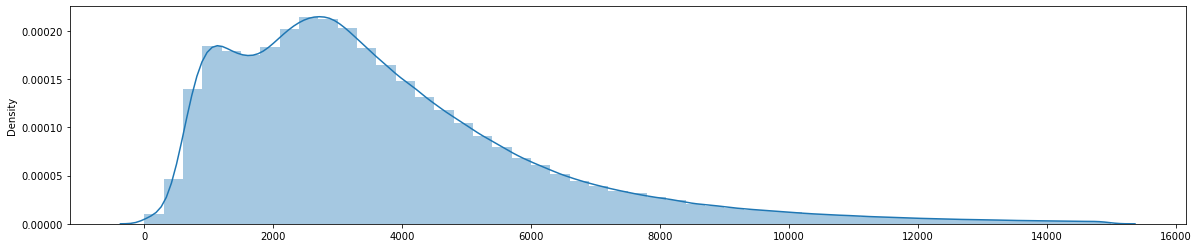

In [222]:
# set to ~ 2sd from mean
outlier_cutoff = 15000
values_sqft_price = result[result["sqft_price"] < outlier_cutoff].sqft_price.values
fig, ax = plt.subplots(figsize=(20, 4))
sns.distplot(values_sqft_price, ax=ax)
plt.show()

/home/elena/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


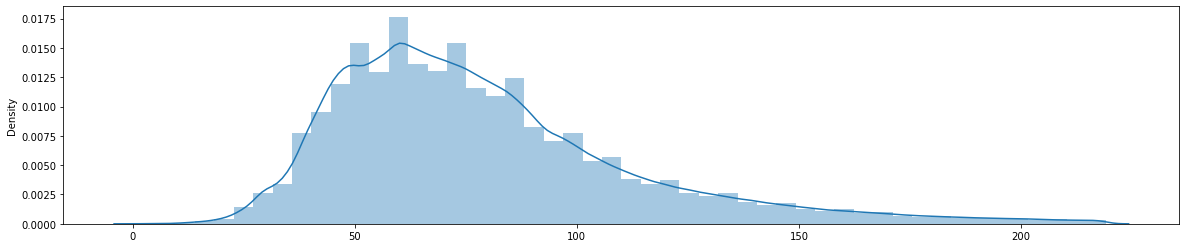

In [221]:
# set to ~ 2sd from mean
outlier_cutoff = 220
values_sqft = result[result["sqft"] < outlier_cutoff].sqft.values
fig, ax = plt.subplots(figsize=(20, 4))
sns.distplot(values_sqft, ax=ax)
plt.show()

In [235]:
engine = psycopg2.connect(database="postgres", user=secrets.user(), password=secrets.password(), host=secrets.host(), port='5432')

sql = """
SELECT 
    g.lsoa, g.lsoa_name, g.rg_name, g.geometry, count(p.brn)

from prices as p

join geo as g
on p.lsoa = g.lsoa
where p.new = 'Y' and p.brn is not null

group by g.lsoa, g.lsoa_name, g.rg_name, g.geometry;
"""

gdf_new = gpd.read_postgis(sql, engine, geom_col='geometry') 
gdf_new.head(2)

,lsoa,lsoa_name,rg_name,geometry,count
0,E01000005,City of London 001E,City of London,"POLYGON ((533807.946 180767.770, 533649.063 18...",80
1,E01000006,Barking and Dagenham 016A,Barking and Dagenham,"POLYGON ((545122.049 184314.931, 545271.917 18...",104


Top 5 regions with new developments sold
          rg_name  count
29  Tower Hamlets  30054
27      Southwark  15528
10      Greenwich  15256
31     Wandsworth  14027
1          Barnet  12940
 

 Top 10 lsoa areas
           lsoa           lsoa_name  count
4298  E01033583         Newham 013G   2198
4292  E01033577         Newham 037E   1791
4223  E01032778  Tower Hamlets 028G   1528
4349  E01033733      Greenwich 036E   1448
3989  E01004562     Wandsworth 002B   1336
2815  E01003250       Lewisham 001E   1285
3668  E01004215  Tower Hamlets 028A   1203
4352  E01033736      Greenwich 004H   1107
4287  E01033572         Barnet 030E   1092
4291  E01033576         Newham 034H   1088


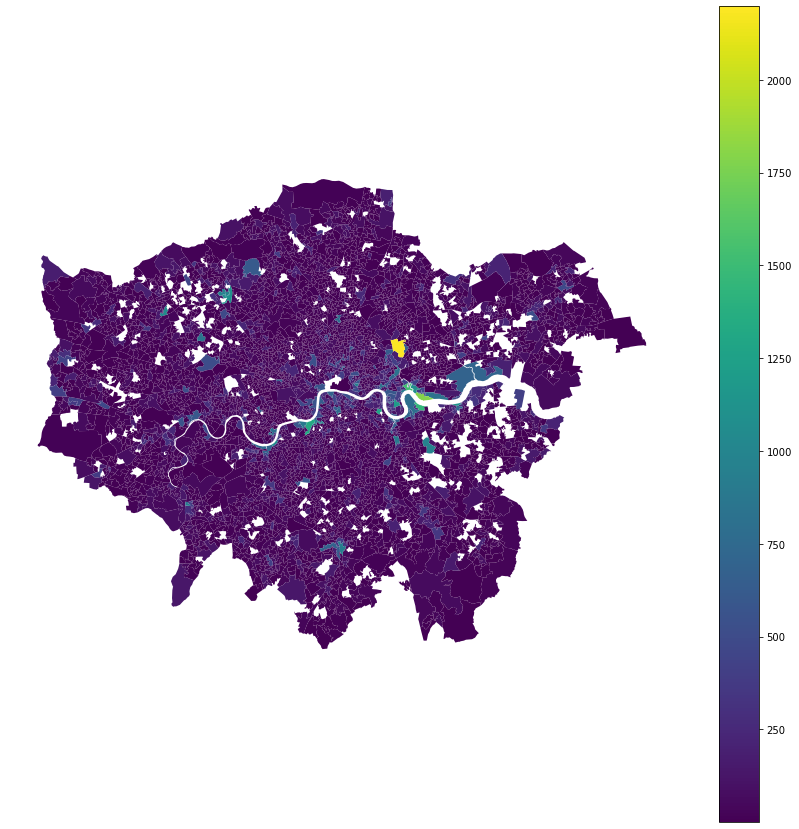

In [245]:
print("Top 5 regions with new developments sold")
print(gdf_new.groupby("rg_name", as_index=False)["count"].sum().sort_values(by="count", ascending=False)[:5])

print(" ")
print("\n Top 10 lsoa areas")
print(gdf_new.sort_values(by="count", ascending=False)[:10][["lsoa", "lsoa_name", "count"]])

fig, ax = plt.subplots(figsize=(15, 15))
ax.axis('off')
gdf_new.plot(ax = ax, column="count",legend=True)
plt.show()

In [349]:
#### Understand the price per sq ft variance across various regions
## London has a few regions with the property prices much higher than the city's average
## which makes it hard to visualize or analyse the prices
## Therefore, separate the data into 2 chunks:
# Those areas with prices being below 1 ST DEV from mean
# Those areas with prices significantly above 1 ST DEV from mean


engine = psycopg2.connect(database="postgres", user=secrets.user(), password=secrets.password(), host=secrets.host(), port='5432')
cur = engine.cursor()
cur.execute("""
SELECT 
    g.rg_name,
    CAST(ROUND(AVG(p.price)::numeric,0 ) as integer) as avg_price,
    CAST(ROUND(AVG(e.total_floor_area)::numeric,0 ) as integer) as avg_sqft,
    CAST(ROUND(AVG(e.number_habitable_rooms)::numeric,0 ) as integer) as avg_rooms,
    CAST(ROUND( AVG(p.price/e.total_floor_area)::numeric, 3 ) as integer) as sqft_price,
    CAST(ROUND( AVG(p.price/e.number_habitable_rooms)::numeric, 3 ) as integer) as price_per_room

from prices as p
join epc as e
on e.brn = p.brn
join geo as g
on p.lsoa = g.lsoa
where e.total_floor_area <> 0 and e.number_habitable_rooms <> 0 and e.number_habitable_rooms is not null and e.total_floor_area is not null
and p.year = 2019
group by g.rg_name;

""")
rows = cur.fetchall()
result = pd.DataFrame(rows, columns = [desc[0] for desc in cur.description])

result["sqft_price_stdev"] = abs(np.round( (result["sqft_price"]-result["sqft_price"].mean()) / result["sqft_price"].std(), 1))
result = result.sort_values(by="sqft_price_stdev", ascending=False)

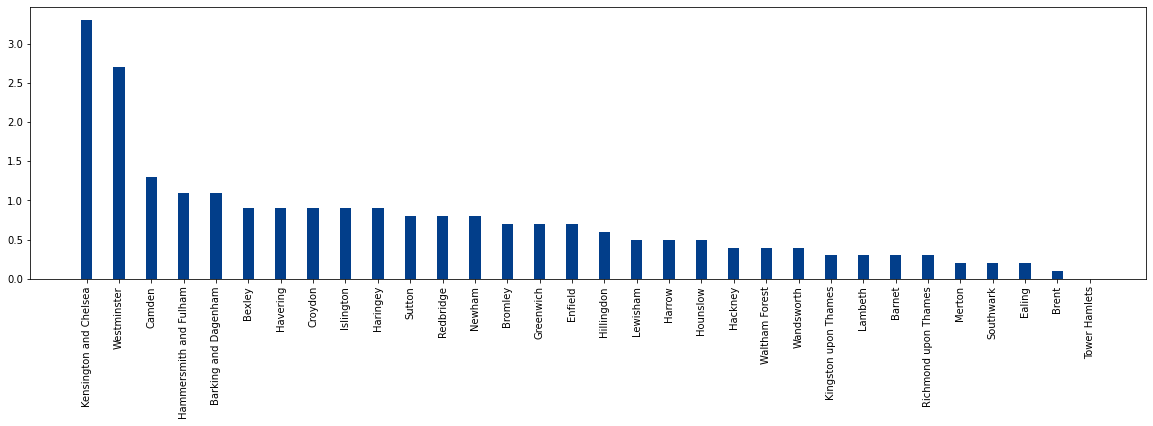

In [350]:
fig, ax = plt.subplots(figsize=(20, 5))

width = 0.35
labels = result["rg_name"].values
x = np.arange(len(labels))
y = result["sqft_price_stdev"].values
ax.bar(x, y, width, color="#023e8a")
ax.set_xticks(x)
ax.tick_params(axis='x', rotation=90)
ax.set_xticklabels(labels)
ax.set_xticklabels(labels)

plt.show()

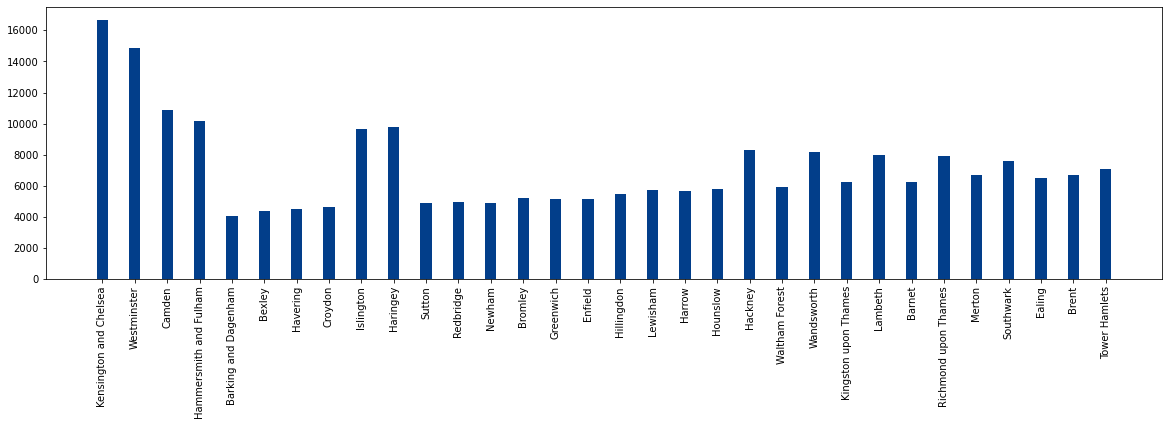

In [371]:
fig, ax = plt.subplots(figsize=(20, 5))

width = 0.35
labels = result["rg_name"].values
x = np.arange(len(labels))
y = result["sqft_price"].values
ax.bar(x, y, width, color="#023e8a")
ax.set_xticks(x)
ax.tick_params(axis='x', rotation=90)
ax.set_xticklabels(labels)
ax.set_xticklabels(labels)

plt.show()

In [351]:
list_of_regions_1stdev = result[result.sqft_price_stdev <1.01]["rg_name"].values
list_of_regions_more1stdev = result[result.sqft_price_stdev > 0.99]["rg_name"].values

In [329]:
engine = psycopg2.connect(database="postgres", user=secrets.user(), password=secrets.password(), host=secrets.host(), port='5432')

sql = """
SELECT 
    g.rg_name, g.lsoa, g.lsoa_name, g.geometry,
    CAST(ROUND(AVG(p.price)::numeric,0 ) as integer) as avg_price,
    CAST(ROUND(AVG(e.total_floor_area)::numeric,0 ) as integer) as avg_sqft,
    CAST(ROUND(AVG(e.number_habitable_rooms)::numeric,0 ) as integer) as avg_rooms,
    CAST(ROUND( AVG(p.price/e.total_floor_area)::numeric, 3 ) as integer) as sqft_price,
    CAST(ROUND( AVG(p.price/e.number_habitable_rooms)::numeric, 3 ) as integer) as price_per_room

from prices as p
join epc as e
on e.brn = p.brn
join geo as g
on p.lsoa = g.lsoa
where e.total_floor_area <> 0 and e.number_habitable_rooms <> 0 and e.number_habitable_rooms is not null and e.total_floor_area is not null
and p.year = 2019

group by g.rg_name, g.lsoa, g.lsoa_name, g.geometry


"""

gdf_all = gpd.read_postgis(sql, engine, geom_col='geometry') 
gdf_all.head(2)

,rg_name,lsoa,lsoa_name,geometry,avg_price,avg_sqft,avg_rooms,sqft_price,price_per_room
0,Barking and Dagenham,E01000006,Barking and Dagenham 016A,"POLYGON ((545122.049 184314.931, 545271.917 18...",272229,63,4,4432,74181
1,Barking and Dagenham,E01000007,Barking and Dagenham 015A,"POLYGON ((544180.347 184700.582, 544317.196 18...",227000,53,3,4178,85424
2,Barking and Dagenham,E01000008,Barking and Dagenham 015B,"MULTIPOLYGON (((543741.001 184566.000, 543806....",256833,74,4,3536,70958
3,Barking and Dagenham,E01000009,Barking and Dagenham 016B,"POLYGON ((544499.837 184704.366, 544630.292 18...",295000,95,4,3137,67271
4,Barking and Dagenham,E01000010,Barking and Dagenham 015C,"POLYGON ((544174.000 184361.000, 544211.000 18...",248487,59,3,4331,90588


Top regions by the highest price per sq ft 

                  rg_name  sqft_price_norm
4             Westminster              1.5
3  Kensington and Chelsea              1.3
1                  Camden              1.0
0    Barking and Dagenham              0.9
2  Hammersmith and Fulham              0.7


/home/elena/anaconda3/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


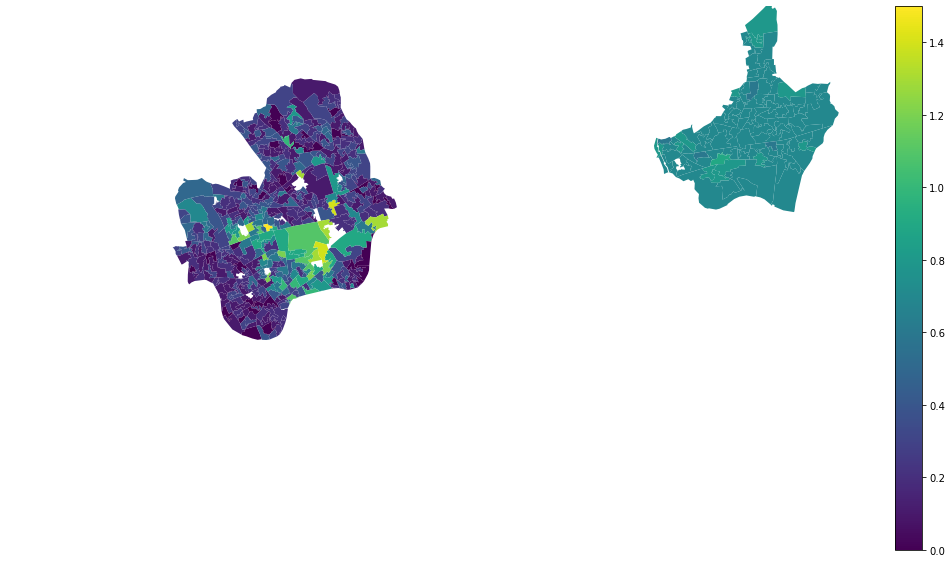

In [376]:
#### Areas within > 1 st dev of the mean price from entire london
##
# Calcs
gdf_all_more1stdev = gdf_all[gdf_all.rg_name.isin(list_of_regions_more1stdev)]
# Recalculate mean, st dev
gdf_all_more1stdev["sqft_price_norm"] = abs(np.round( (gdf_all_more1stdev["sqft_price"]-gdf_all_more1stdev["sqft_price"].mean()) / gdf_all_more1stdev["sqft_price"].std(), 1))
# Remove outliers (> 2 st dev)
gdf_all_more1stdev = gdf_all_more1stdev[gdf_all_more1stdev["sqft_price_norm"] <2]

print("Top regions by the highest price per sq ft \n")
print(gdf_all_more1stdev.groupby("rg_name", as_index=False)["sqft_price_norm"].max().sort_values(by="sqft_price_norm", ascending=False))

fig, ax = plt.subplots(figsize=(20, 10))
ax.axis('off')
gdf_all_more1stdev.plot(ax = ax, column="sqft_price_norm", legend=True)
adj_x = 10000
adj_y = 10000
minx, miny, maxx, maxy = gdf_all.total_bounds
ax.set_xlim(minx + adj_x, maxx - adj_x)
ax.set_ylim(miny  + adj_y, maxy - adj_y)
plt.show()

/home/elena/anaconda3/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


Top regions by the highest price per sq ft 

          rg_name  sqft_price_norm
14      Islington              1.9
2           Brent              1.9
24  Tower Hamlets              1.9
0          Barnet              1.8
8         Hackney              1.7


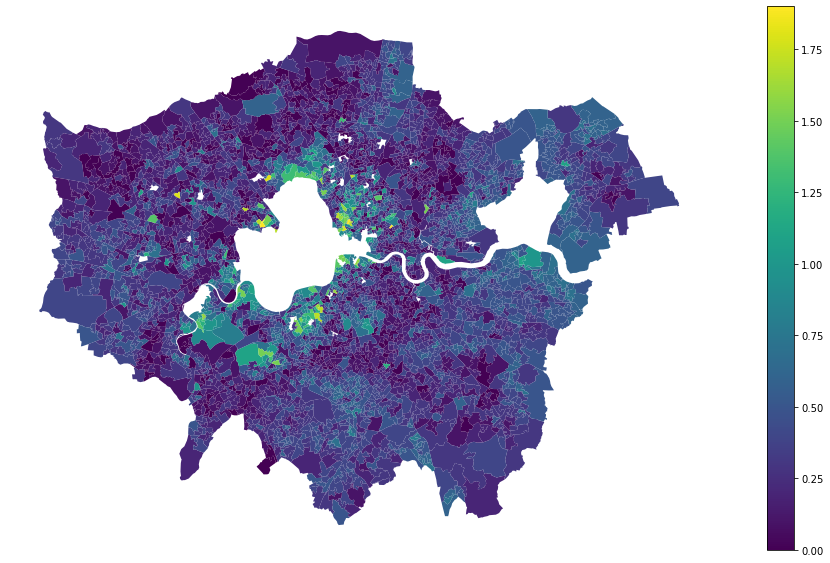

In [377]:
#### Areas within 1 st dev of the mean price from entire london
##
# Calcs
gdf_all_1stdev = gdf_all[gdf_all.rg_name.isin(list_of_regions_1stdev)]
# Recalculate mean, st dev
gdf_all_1stdev["sqft_price_norm"] = abs(np.round( (gdf_all_1stdev["sqft_price"]-gdf_all_1stdev["sqft_price"].mean()) / gdf_all_1stdev["sqft_price"].std(), 1))
# Remove outliers (> 2 st dev)
gdf_all_1stdev = gdf_all_1stdev[gdf_all_1stdev["sqft_price_norm"] <2]

print("Top regions by the highest price per sq ft \n")
print(gdf_all_1stdev.groupby("rg_name", as_index=False)["sqft_price_norm"].max().sort_values(by="sqft_price_norm", ascending=False)[:5])


fig, ax = plt.subplots(figsize=(20, 10))
ax.axis('off')
gdf_all_1stdev.plot(ax = ax, column="sqft_price_norm", legend=True)

plt.show()

In [378]:
gdf_all.head()

,rg_name,lsoa,lsoa_name,geometry,avg_price,avg_sqft,avg_rooms,sqft_price,price_per_room,sqft_price_norm,sqft_price_norm2
0,Barking and Dagenham,E01000006,Barking and Dagenham 016A,"POLYGON ((545122.049 184314.931, 545271.917 18...",272229,63,4,4432,74181,0.4,0.01
1,Barking and Dagenham,E01000007,Barking and Dagenham 015A,"POLYGON ((544180.347 184700.582, 544317.196 18...",227000,53,3,4178,85424,0.5,0.01
2,Barking and Dagenham,E01000008,Barking and Dagenham 015B,"MULTIPOLYGON (((543741.001 184566.000, 543806....",256833,74,4,3536,70958,0.6,0.01
3,Barking and Dagenham,E01000009,Barking and Dagenham 016B,"POLYGON ((544499.837 184704.366, 544630.292 18...",295000,95,4,3137,67271,0.7,0.01
4,Barking and Dagenham,E01000010,Barking and Dagenham 015C,"POLYGON ((544174.000 184361.000, 544211.000 18...",248487,59,3,4331,90588,0.5,0.01


In [388]:
engine = psycopg2.connect(database="postgres", user=secrets.user(), password=secrets.password(), host=secrets.host(), port='5432')
cur = engine.cursor()
cur.execute("""
SELECT 
    CAST (p.year AS INTEGER), p.new, p.duration, p.type, g.rg_name,
    CAST(ROUND(AVG(p.price)::numeric,0 ) as integer) as avg_price,
    CAST(ROUND(AVG(e.total_floor_area)::numeric,0 ) as integer) as avg_sqft,
    CAST(ROUND(AVG(e.number_habitable_rooms)::numeric,0 ) as integer) as avg_rooms,
    CAST(ROUND(AVG(p.price/e.total_floor_area)::numeric, 3 ) as integer) as sqft_price,
    CAST(ROUND(AVG(p.price/e.number_habitable_rooms)::numeric, 3 ) as integer) as price_per_room

from prices as p
join epc as e
on e.brn = p.brn
join geo as g
on p.lsoa = g.lsoa
where e.total_floor_area <> 0 and e.number_habitable_rooms <> 0 and e.number_habitable_rooms is not null and e.total_floor_area is not null

group by p.year, p.new, p.duration, p.type, g.rg_name
having CAST(ROUND(AVG(p.price/e.total_floor_area)::numeric, 3 ) as integer) < 25000;

""")
rows = cur.fetchall()
result = pd.DataFrame(rows, columns = [desc[0] for desc in cur.description])


In [389]:
result

,year,new,duration,type,rg_name,avg_price,avg_sqft,avg_rooms,sqft_price,price_per_room
0,1995,N,F,D,Barking and Dagenham,57045,104,6,569,11435
1,1995,N,F,D,Barnet,255030,204,7,1319,34747
2,1995,N,F,D,Bexley,109778,110,5,1063,21771
3,1995,N,F,D,Brent,153343,163,7,1054,27125
4,1995,N,F,D,Bromley,169613,156,6,1177,26857
...,...,...,...,...,...,...,...,...,...,...
9519,2020,Y,L,F,Lambeth,543333,96,3,5688,181111
9520,2020,Y,L,F,Lewisham,360250,64,3,5611,120083
9521,2020,Y,L,F,Tower Hamlets,93150,46,2,2048,46575
9522,2020,Y,L,F,Waltham Forest,262500,31,1,8615,262500


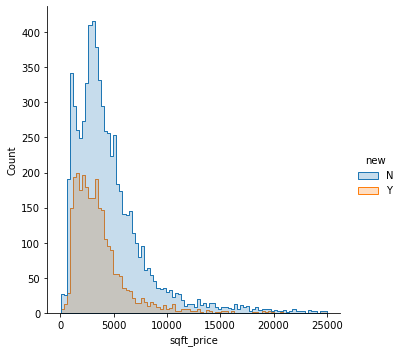

In [412]:
# all
sns.displot(result, x="sqft_price", hue="new", element="step")

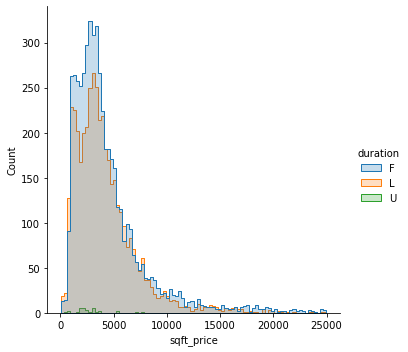

In [413]:
# all
sns.displot(result, x="sqft_price", hue="duration", element="step")

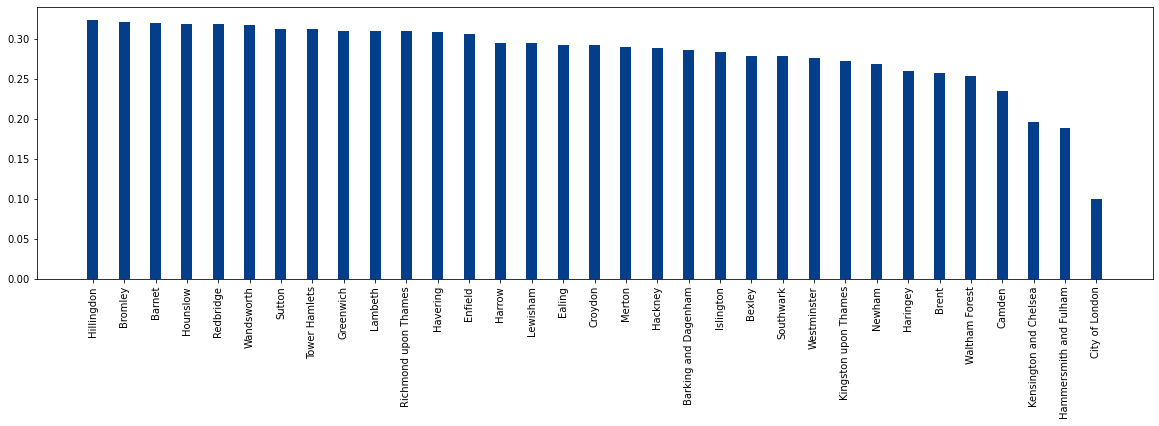

In [434]:
pv = pd.pivot_table(result, index="rg_name", columns="new", aggfunc="count", values="avg_price").reset_index()
pv["perc_new"] = pv["Y"]/ (pv["N"] + pv["Y"])
pv = pv.sort_values(by="perc_new", ascending=False)

fig, ax = plt.subplots(figsize=(20, 5))

width = 0.35
labels = pv["rg_name"].values
x = np.arange(len(labels))
y = pv["perc_new"].values
ax.bar(x, y, width, color="#023e8a")
ax.set_xticks(x)
ax.tick_params(axis='x', rotation=90)
ax.set_xticklabels(labels)
ax.set_xticklabels(labels)

plt.show()

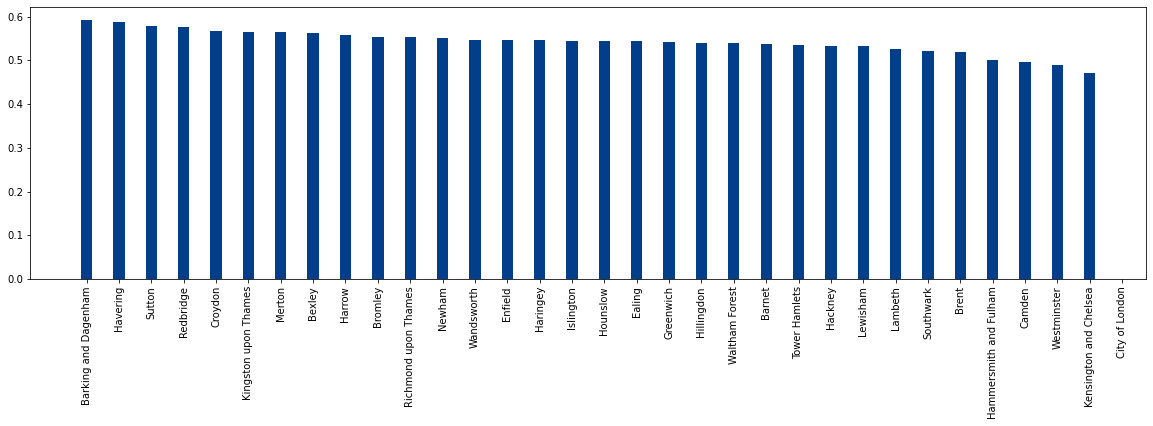

In [436]:
pv = pd.pivot_table(result, index="rg_name", columns="duration", aggfunc="count", values="avg_price").reset_index()
pv["perc_f"] = pv["F"]/ (pv["F"] + pv["L"])
pv = pv.sort_values(by="perc_f", ascending=False)

fig, ax = plt.subplots(figsize=(20, 5))

width = 0.35
labels = pv["rg_name"].values
x = np.arange(len(labels))
y = pv["perc_f"].values
ax.bar(x, y, width, color="#023e8a")
ax.set_xticks(x)
ax.tick_params(axis='x', rotation=90)
ax.set_xticklabels(labels)
ax.set_xticklabels(labels)

plt.show()


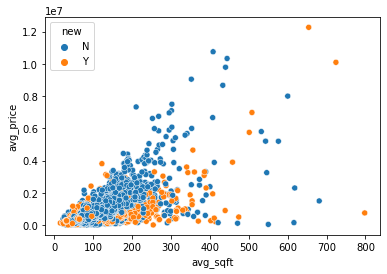

In [410]:
sns.scatterplot(data=result, x="avg_sqft", y="avg_price", hue="new")

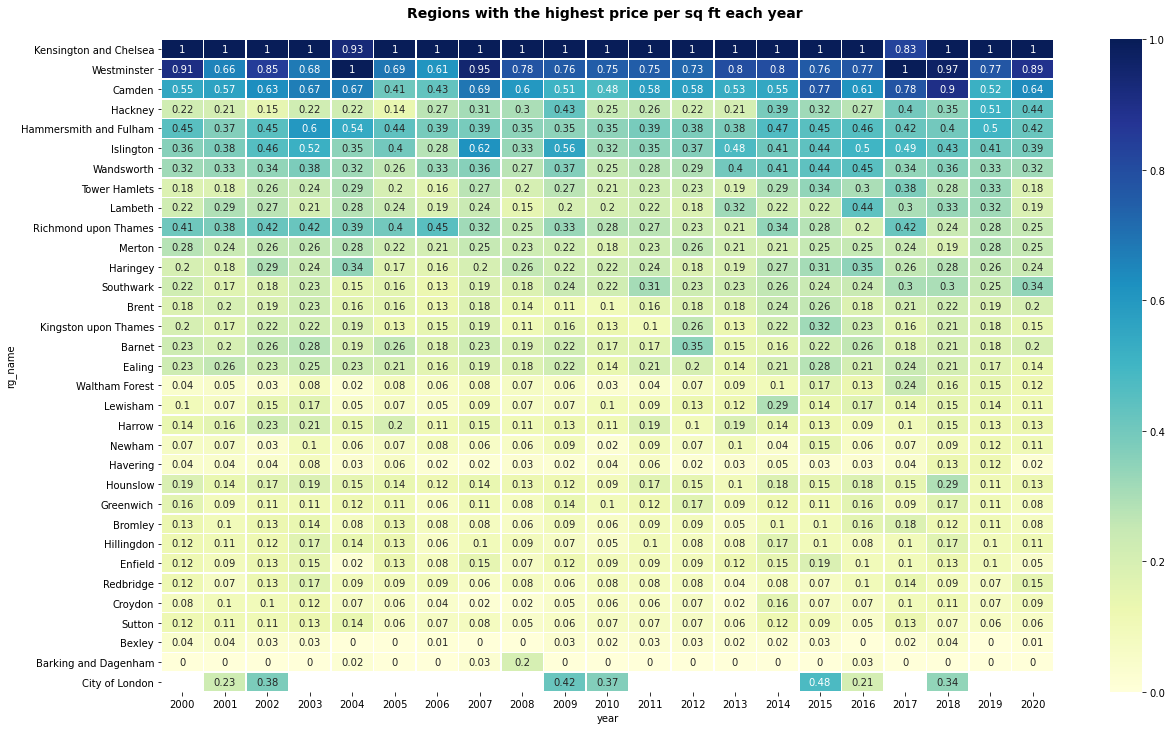

In [423]:
#### By Region view prices
####

# Reshape data into pivot table
result_pv = pd.pivot_table(result[result.year > 1999], index="rg_name", columns="year", values="sqft_price")
# Normalize data across each row, for each region ensure the avg price is represented as a number between 0 and 1
result_pv2 = result_pv.subtract(result_pv.min(axis=1), axis=0).div(result_pv.max(axis=1) -result_pv.min(axis=1), axis=0).round(2).sort_values(by=2019, ascending=False)
result_pv3 = result_pv.subtract(result_pv.min(axis=0), axis=1).div(result_pv.max(axis=0) -result_pv.min(axis=0), axis=1).round(2).sort_values(by=2019, ascending=False)

# Plot 
fig, ax = plt.subplots(figsize=(20, 12))
sns.heatmap(result_pv3, annot=True, linewidths=.5, ax=ax, cmap="YlGnBu")
ax.set_title("Regions with the highest price per sq ft each year \n", fontweight='bold', fontsize=14)
plt.show()

In [442]:
engine = psycopg2.connect(database="postgres", user=secrets.user(), password=secrets.password(), host=secrets.host(), port='5432')
cur = engine.cursor()
cur.execute("""
SELECT 

    CAST (p.year AS INTEGER), h.index, p.lsoa, g.geometry,
    CAST(ROUND(AVG(p.price)::numeric,0 ) as integer) as avg_price,
    CAST(ROUND(AVG(e.total_floor_area)::numeric,0 ) as integer) as avg_sqft,
    CAST(ROUND(AVG(p.price/e.total_floor_area)::numeric, 3 ) as integer) as sqft_price

from prices as p
join epc as e
on e.brn = p.brn
join (select year, avg(index) as index from hpi_ir group by 1
) as h
on p.year = h.year
join geo as g
on p.lsoa = g.lsoa

where e.total_floor_area <> 0 and e.number_habitable_rooms <> 0 and e.number_habitable_rooms is not null and e.total_floor_area is not null

group by p.year, h.index, p.lsoa, g.geometry;

""")
rows = cur.fetchall()
result = pd.DataFrame(rows, columns = [desc[0] for desc in cur.description])

In [444]:
engine = psycopg2.connect(database="postgres", user=secrets.user(), password=secrets.password(), host=secrets.host(), port='5432')

sql = """
SELECT 

    CAST (p.year AS INTEGER), h.index, p.lsoa, g.geometry,
    CAST(ROUND(AVG(p.price)::numeric,0 ) as integer) as avg_price,
    CAST(ROUND(AVG(e.total_floor_area)::numeric,0 ) as integer) as avg_sqft,
    CAST(ROUND(AVG(p.price/e.total_floor_area)::numeric, 3 ) as integer) as sqft_price

from prices as p
join epc as e
on e.brn = p.brn
join (select year, avg(index) as index from hpi_ir group by 1
) as h
on p.year = h.year
join geo as g
on p.lsoa = g.lsoa

where e.total_floor_area <> 0 and e.number_habitable_rooms <> 0 and e.number_habitable_rooms is not null and e.total_floor_area is not null

group by p.year, h.index, p.lsoa, g.geometry;

"""

gdf_all = gpd.read_postgis(sql, engine, geom_col='geometry') 
gdf_all.head(2)

,year,index,lsoa,geometry,avg_price,avg_sqft,sqft_price
0,1995,18.548293,E01000006,"POLYGON ((545122.049 184314.931, 545271.917 18...",69800,99,723
1,1995,18.548293,E01000007,"POLYGON ((544180.347 184700.582, 544317.196 18...",43000,71,605


In [456]:
gdf_all["sqft_price_lag1"] = gdf_all.groupby("lsoa")["sqft_price"].shift(+1)
gdf_all["indexlag1"] = gdf_all.groupby("lsoa")["index"].shift(+1)
gdf_all["index_perc"] = gdf_all["indexlag1"]/gdf_all["index"]-1
gdf_all["sqft_price_perc"] = gdf_all["sqft_price_lag1"]/gdf_all["sqft_price"]-1

In [465]:
gdf_all["diff"] = gdf_all["sqft_price_perc"] - gdf_all["index_perc"] 
gdf_all["diff2"]  = [1 if x>0.1 else 0 for x in gdf_all["diff"] ]

In [476]:
gdf_all

,year,index,lsoa,geometry,avg_price,avg_sqft,sqft_price,sqft_price_lag1,indexlag1,index_perc,sqft_price_perc,diff,diff2
0,1995,18.548293,E01000006,"POLYGON ((545122.049 184314.931, 545271.917 18...",69800,99,723,NaN,NaN,NaN,NaN,NaN,0
1,1995,18.548293,E01000007,"POLYGON ((544180.347 184700.582, 544317.196 18...",43000,71,605,NaN,NaN,NaN,NaN,NaN,0
2,1995,18.548293,E01000009,"POLYGON ((544499.837 184704.366, 544630.292 18...",54333,96,556,NaN,NaN,NaN,NaN,NaN,0
3,1995,18.548293,E01000010,"POLYGON ((544174.000 184361.000, 544211.000 18...",52000,79,704,NaN,NaN,NaN,NaN,NaN,0
4,1995,18.548293,E01000011,"POLYGON ((544523.402 184789.039, 544667.055 18...",38184,65,628,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
124770,2020,119.680092,E01033742,"POLYGON ((544642.680 179824.674, 544766.313 17...",309000,73,4353,5238.0,116.935857,-0.02293,0.203308,0.226238,1
124771,2020,119.680092,E01033743,"POLYGON ((546579.195 181097.813, 546687.036 18...",295889,68,4507,4268.0,116.935857,-0.02293,-0.053029,-0.030099,0
124772,2020,119.680092,E01033744,"POLYGON ((544536.486 179447.115, 544602.630 17...",359875,66,5517,4998.0,116.935857,-0.02293,-0.094073,-0.071143,0
124773,2020,119.680092,E01033745,"POLYGON ((546415.745 180152.270, 546320.715 18...",298250,73,4057,3990.0,116.935857,-0.02293,-0.016515,0.006415,0


In [496]:
# fig, ax = plt.subplots(figsize=(20, 10))
# ax.axis('off')
# df = gdf_all.groupby(["lsoa"], as_index=False)["diff2"].sum().sort_values(by="diff2", ascending=False).merge(gdf_all[["lsoa", "geometry"]], how="left", on="lsoa")
# gdf = gpd.GeoDataFrame(df, crs="EPSG:4326", geometry="geometry")
# gdf.plot(ax = ax, column="diff2", legend=True)

# plt.show()



In [224]:
# # Get Data from AWS RDS PostgresSQL DB (all data within the database is publicly available and been scrapped and collected by myself)

# engine = psycopg2.connect(database="postgres", user=secrets.user(), password=secrets.password(), host=secrets.host(), port='5432')
# cur = engine.cursor()

# cur.execute("""

# SELECT 
#     CAST (p.year AS INTEGER), p.new, p.duration, p.type, g.rg_name, g.geometry,
#     CAST(ROUND(AVG(p.price)::numeric,0 ) as integer) as avg_price,
#     CAST(ROUND(AVG(e.total_floor_area)::numeric,0 ) as integer) as avg_sqft,
#     CAST(ROUND(AVG(e.number_habitable_rooms)::numeric,0 ) as integer) as avg_rooms,
#     CAST(ROUND( AVG(p.price/e.total_floor_area)::numeric, 3 ) as integer) as sqft_price,
#     CAST(ROUND( AVG(p.price/e.number_habitable_rooms)::numeric, 3 ) as integer) as price_per_room

# from prices as p
# join epc as e
# on e.brn = p.brn
# join geo as g
# on p.lsoa = g.lsoa
# where e.total_floor_area <> 0 and e.number_habitable_rooms <> 0 and e.number_habitable_rooms is not null and e.total_floor_area is not null

# group by p.year, p.new, p.duration, p.type, g.rg_name, g.geometry;

# """)
# rows = cur.fetchall()
# result = pd.DataFrame(rows, columns = [desc[0] for desc in cur.description])
# result.head(2)

,year,new,duration,type,rg_name,avg_price,avg_sqft,avg_rooms,sqft_price,price_per_room
0,1995,N,F,D,Barking and Dagenham,57045,104,6,569,11435
1,1995,N,F,D,Barnet,255030,204,7,1319,34747
2,1995,N,F,D,Bexley,109778,110,5,1063,21771
3,1995,N,F,D,Brent,153343,163,7,1054,27125
4,1995,N,F,D,Bromley,169613,156,6,1177,26857
...,...,...,...,...,...,...,...,...,...,...
9591,2020,Y,L,F,Lambeth,543333,96,3,5688,181111
9592,2020,Y,L,F,Lewisham,360250,64,3,5611,120083
9593,2020,Y,L,F,Tower Hamlets,93150,46,2,2048,46575
9594,2020,Y,L,F,Waltham Forest,262500,31,1,8615,262500


In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.axis('off')
gdf.plot(ax = ax, column="avg", \
         legend=True, \
         missing_kwds={
            "color": "lightgrey",
            "edgecolor": "red",
            "hatch": "///",
            "label": "Missing values",},
        )

plt.show()

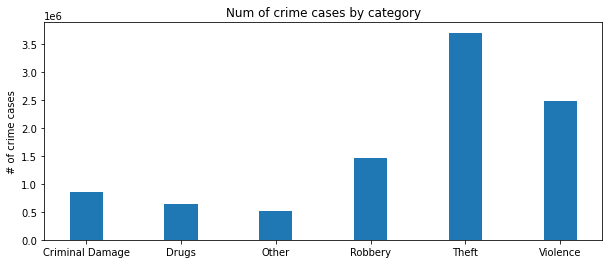

In [20]:
fig, ax = plt.subplots(figsize = (10, 4))

df = result.groupby("cat_group")["sum"].sum().reset_index()
width = 0.35
labels = df["cat_group"].to_list()
x = np.arange(len(labels))
y = df["sum"].to_list()

ax.bar(x, y, width)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('# of crime cases')
ax.set_title('Num of crime cases by category')
ax.set_xticks(x)
ax.set_xticklabels(labels)

plt.show()

In [ ]:
cur.execute("""

select * from geo limit 5;


""")
rows = cur.fetchall()
result = pd.DataFrame(rows, columns = [desc[0] for desc in cur.description])
result

In [20]:


sql = """

select g.lsoa, g.lsoa_name, g.geometry, avg(p.price)
from geo as g
left join prices2 as p
on p.lsoa = g.lsoa
group by g.lsoa, g.geometry, g.lsoa_name;

"""

gdf = gpd.read_postgis(sql, engine, geom_col='geometry') 
gdf

,lsoa,lsoa_name,geometry,avg
0,E01004412,Waltham Forest 015A,"POLYGON ((537860.816 189145.369, 537905.112 18...",262241.237349
1,E01003435,Merton 014E,"POLYGON ((528734.439 168833.422, 528956.432 16...",214510.526730
2,E01001925,Hammersmith and Fulham 025A,"POLYGON ((525694.651 176397.904, 525706.501 17...",989160.753902
3,E01003868,Richmond upon Thames 007B,"POLYGON ((516754.999 174347.000, 516818.698 17...",425224.617481
4,E01002608,Hounslow 028A,"POLYGON ((512003.000 171946.444, 511991.462 17...",208673.230337
...,...,...,...,...
4830,E01004449,Waltham Forest 018E,"POLYGON ((536911.470 188320.534, 536901.336 18...",192131.314721
4831,E01003950,Southwark 032B,"POLYGON ((534453.263 173952.999, 534526.349 17...",251287.099812
4832,E01004410,Waltham Forest 013B,"POLYGON ((537920.381 189571.503, 537836.610 18...",246760.345840
4833,E01002716,Islington 014A,"POLYGON ((532740.664 184817.607, 532890.029 18...",285486.203922


In [37]:
gdf[gdf.avg.isna()]

,lsoa,lsoa_name,geometry,avg
4,E01002608,Hounslow 028A,"POLYGON ((512003.000 171946.444, 511991.462 17...",NaN
12,E01002370,Havering 028C,"POLYGON ((552340.879 183213.927, 552799.757 18...",NaN
15,E01004004,Southwark 023C,"POLYGON ((535272.030 177008.813, 535297.517 17...",NaN
16,E01003947,Southwark 033C,"POLYGON ((533606.494 172274.543, 533648.410 17...",NaN
17,E01004599,Wandsworth 025E,"POLYGON ((525110.917 173022.766, 525190.784 17...",NaN
...,...,...,...,...
4819,E01001662,Greenwich 037A,"POLYGON ((539552.478 178604.042, 539533.000 17...",NaN
4820,E01001840,Hackney 022B,"POLYGON ((535262.024 184382.712, 535374.145 18...",NaN
4823,E01001163,Croydon 002E,"POLYGON ((532439.238 171017.796, 532501.048 17...",NaN
4831,E01003950,Southwark 032B,"POLYGON ((534453.263 173952.999, 534526.349 17...",NaN


/home/elena/anaconda3/lib/python3.8/site-packages/geopandas/plotting.py:373: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


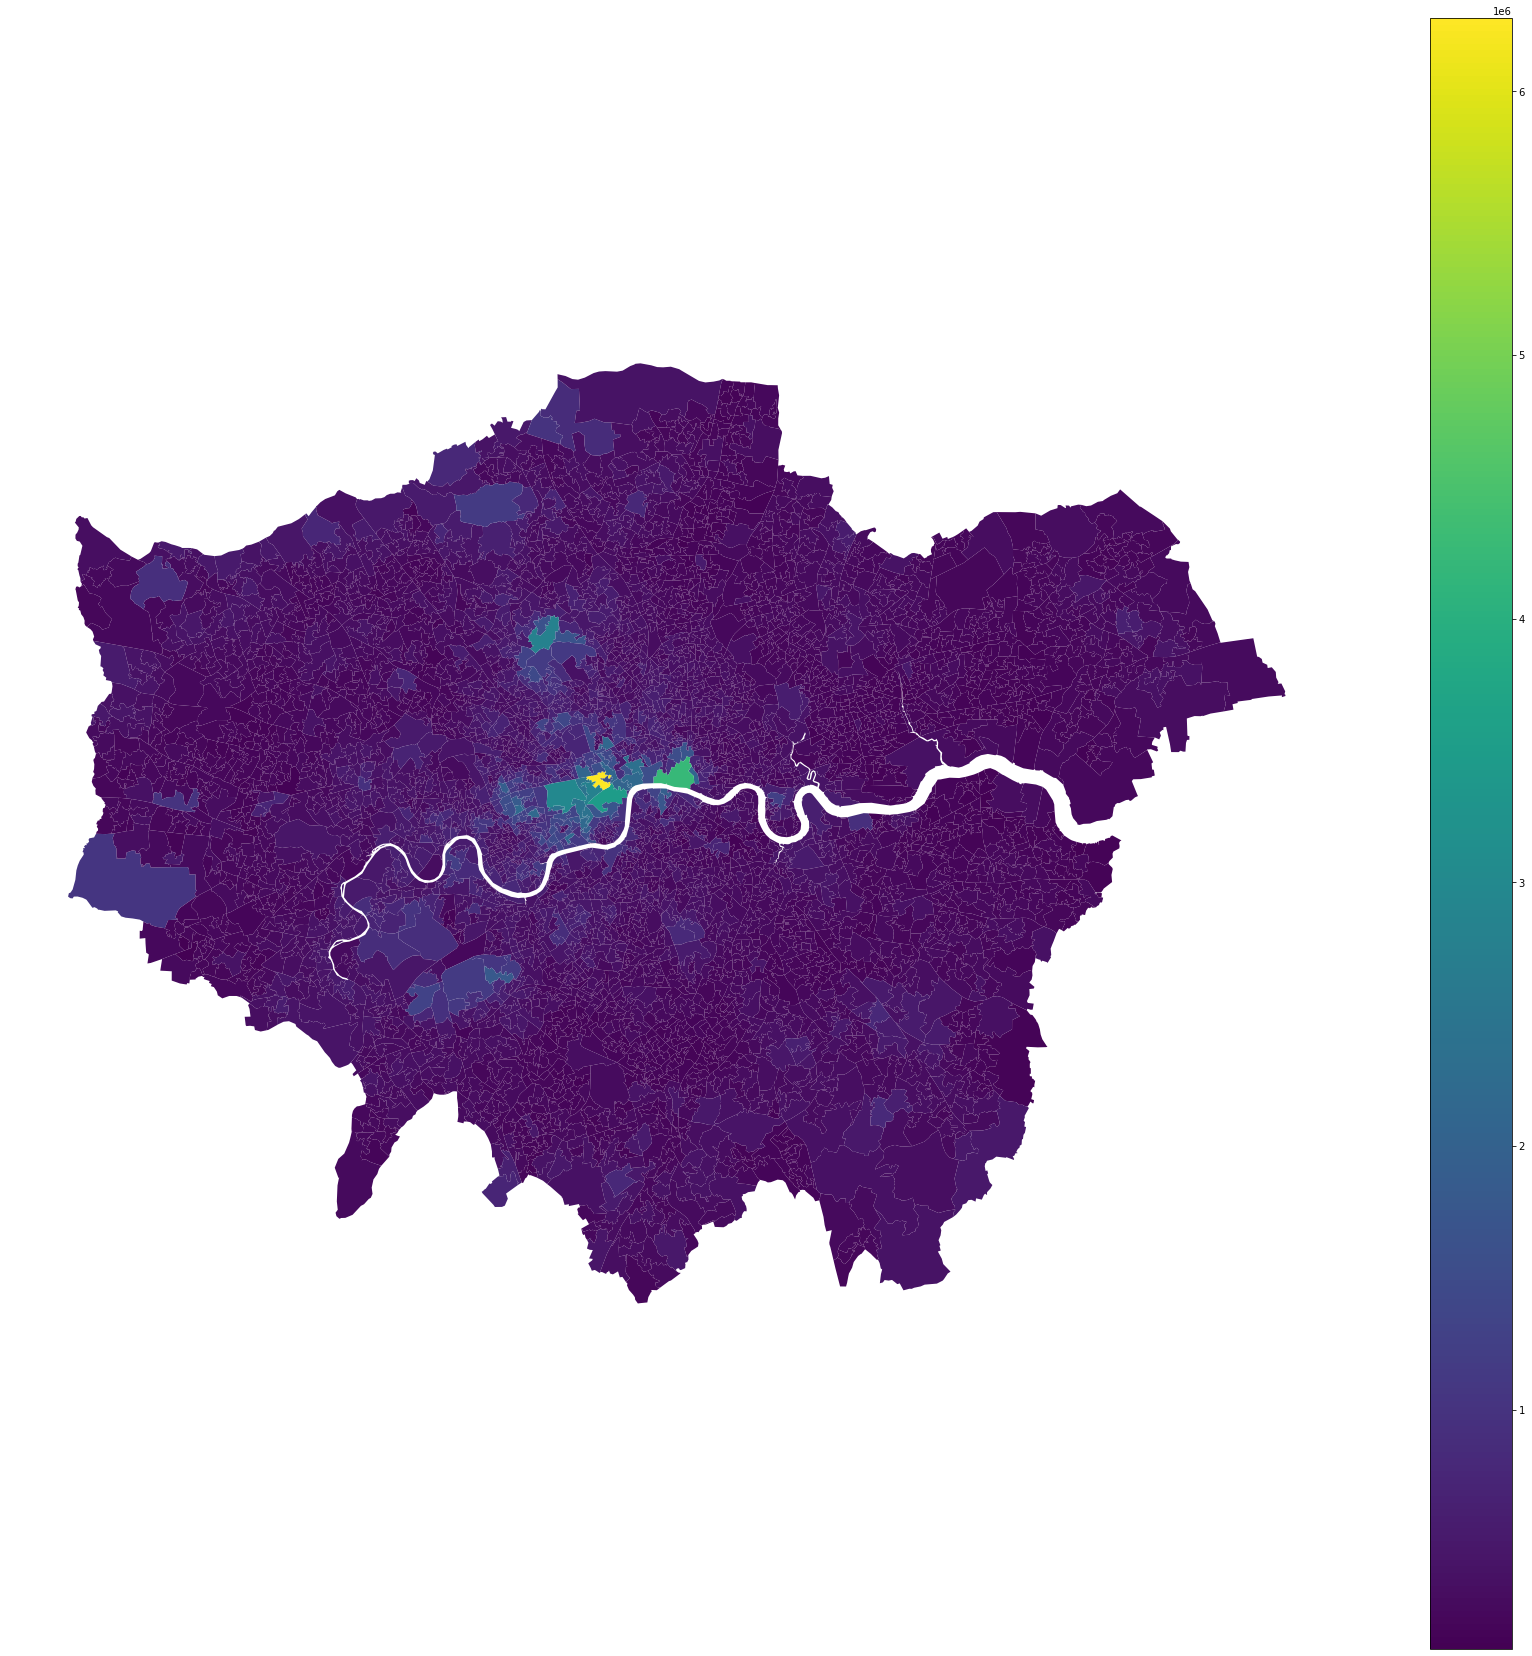

In [23]:
fig, ax = plt.subplots(figsize=(30, 30))
ax.axis('off')
gdf.plot(ax = ax, column="avg", \
         legend=True, \
         missing_kwds={
            "color": "lightgrey",
            "edgecolor": "red",
            "hatch": "///",
            "label": "Missing values",},
        )

plt.show()

In [8]:
gdf

,lsoa,lsoa_name,rg,rg_name,no_of_res,pop_den,geometry
0,E01000001,City of London 001A,E12000007,City of London,1465.0,112.9,"POLYGON ((532105.092 182011.230, 532162.491 18..."
1,E01000002,City of London 001B,E12000007,City of London,1436.0,62.9,"POLYGON ((532746.813 181786.891, 532671.688 18..."
2,E01000003,City of London 001C,E12000007,City of London,1346.0,227.7,"POLYGON ((532135.145 182198.119, 532158.250 18..."
3,E01000005,City of London 001E,E12000007,City of London,985.0,52.0,"POLYGON ((533807.946 180767.770, 533649.063 18..."
4,E01000006,Barking and Dagenham 016A,E12000007,Barking and Dagenham,1703.0,116.2,"POLYGON ((545122.049 184314.931, 545271.917 18..."
